In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [10]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print "dimension de las imagenes y las clases", X.shape, y.shape

dimension de las imagenes y las clases (1500, 784) (1500,)


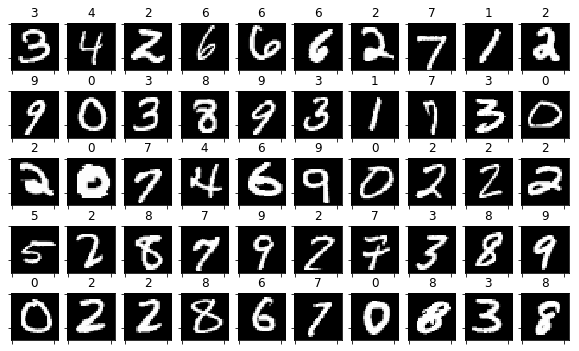

In [11]:
perm = np.random.permutation(range(X.shape[0]))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Autoencoder for compression

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=.2)

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.backend import clear_session

In [14]:
def get_model_A(input_dim, hidden_size, code_size):
    clear_session()
    model = Sequential()
    model.add(Dense(hidden_size, activation='relu', input_dim=input_dim))
    model.add(Dense(code_size, activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.reset_states()
    return model

porqué sigmoide en la última capa. qué pasaría si ponemos tanh o linear

In [15]:
model = get_model_A(input_dim=X.shape[1], hidden_size=256, code_size=24)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 24)                6168      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6400      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               201488    
Total params: 415,016
Trainable params: 415,016
Non-trainable params: 0
_________________________________________________________________


try with larger layer, try with more layers

In [16]:
model.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
1200/1200 [==============================] - 2s 1ms/step - loss: 0.1074
Epoch 2/100
1200/1200 [==============================] - 1s 465us/step - loss: 0.0695
Epoch 3/100
1200/1200 [==============================] - 1s 528us/step - loss: 0.0576
Epoch 4/100
1200/1200 [==============================] - 1s 464us/step - loss: 0.0469
Epoch 5/100
1200/1200 [==============================] - 1s 434us/step - loss: 0.0402
Epoch 6/100
1200/1200 [==============================] - 1s 612us/step - loss: 0.0361
Epoch 7/100
1200/1200 [==============================] - 1s 568us/step - loss: 0.0327
Epoch 8/100
1200/1200 [==============================] - 1s 421us/step - loss: 0.0300
Epoch 9/100
1200/1200 [==============================] - 1s 429us/step - loss: 0.0276
Epoch 10/100
1200/1200 [==============================] - 0s 396us/step - loss: 0.0256
Epoch 11/100
1200/1200 [==============================] - 1s 517us/step - loss: 0.0241
Epoch 12/100
1200/1200 [==============================

1200/1200 [==============================] - 1s 466us/step - loss: 0.0068
Epoch 96/100
1200/1200 [==============================] - 1s 614us/step - loss: 0.0068
Epoch 97/100
1200/1200 [==============================] - 0s 372us/step - loss: 0.0067
Epoch 98/100
1200/1200 [==============================] - 0s 353us/step - loss: 0.0067
Epoch 99/100
1200/1200 [==============================] - 1s 512us/step - loss: 0.0067
Epoch 100/100
1200/1200 [==============================] - 0s 364us/step - loss: 0.0066


### show reconstruction on sampled test images

In [17]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

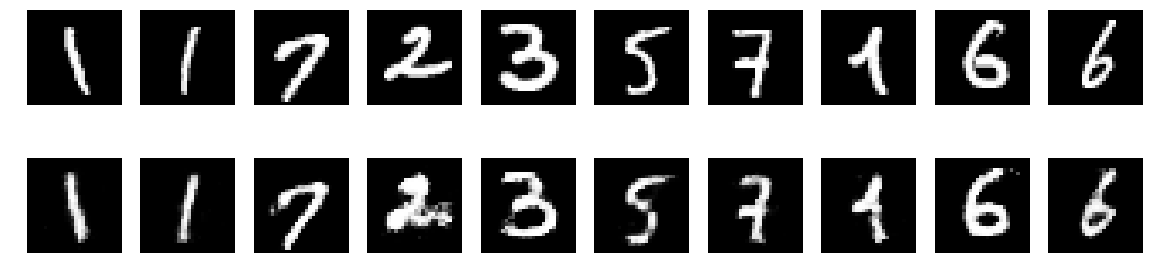

In [18]:
plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    

### show encodings

In [28]:
from keras import backend as K
clear_session()
l1_output = K.function([model.input, K.learning_phase()], [model.layers[1].output])


ValueError: Tensor Tensor("dense_1/Relu:0", shape=(?, 24), dtype=float32) is not an element of this graph.

In [29]:
X_sample_encoded = l1_output([X_sample,1.])[0]

FailedPreconditionError: Error while reading resource variable dense_1/bias from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/dense_1/bias)
	 [[Node: dense_1/BiasAdd/ReadVariableOp = ReadVariableOp[dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_1/bias)]]

NameError: name 'X_sample_encoded' is not defined

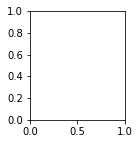

In [23]:
plt.figure(figsize=(20,2))
for i in range(len(X_sample)):
    plt.subplot(1,len(X_sample),i+1)
    plt.imshow(X_sample_encoded[i].reshape(4,-1), cmap=plt.cm.Greys_r)
    plt.axis("off")


# Autoencoder for image denoising

observe reconstruction when fed with noisy data


In [30]:
def add_noise(x, noise_level=.2):
    return x + np.random.normal(size=x.shape)*noise_level

In [31]:
X_sample_noisy = add_noise(X_sample)
X_pred_noisy   = model.predict(X_sample_noisy)

NotFoundError: FeedInputs: unable to find feed output dense_input:0

In [ ]:
plt.figure(figsize=(20,5))
for i in range(len(X_sample_noisy)):
    plt.subplot(2,len(X_sample_noisy),i+1)
    plt.imshow(X_sample_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample_noisy),len(X_sample_noisy)+i+1)
    plt.imshow(X_pred_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    

but if we train with noisy data reconstruction improves



In [ ]:
n_model = get_model_A(input_dim=X.shape[1], hidden_size=128, code_size=16)
X_train_noisy = add_noise(X_train)

n_model.fit(X_train_noisy, X_train_noisy, epochs=100, batch_size=32)

In [ ]:
X_sample_noisy = add_noise(X_sample)
X_pred_noisy   = n_model.predict(X_sample_noisy)

plt.figure(figsize=(20,5))
for i in range(len(X_sample_noisy)):
    plt.subplot(2,len(X_sample_noisy),i+1)
    plt.imshow(X_sample_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample_noisy),len(X_sample_noisy)+i+1)
    plt.imshow(X_pred_noisy[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    